<a href="https://colab.research.google.com/github/Ebenco36/EbencoAbacus/blob/master/nlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [5]:

# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
deu_eng = deu_eng[:50000,:]

deu_eng
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['Run', 'Lauf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ...,
       ['I wholeheartedly agree', 'Ich stimme rückhaltlos zu',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1488273 (Spamster) & #1693172 (al_ex_an_der)'],
       ['I will always love you', 'Ich werde dich immer lieben',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #853146 (piksea) & #395302 (xtofu80)'],
       ['I will be back by nine', 'Um neun bin ich wieder zurück',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #72281 (CK) & #345033 (lilygilder)']],
      dtype='<U537')

In [0]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

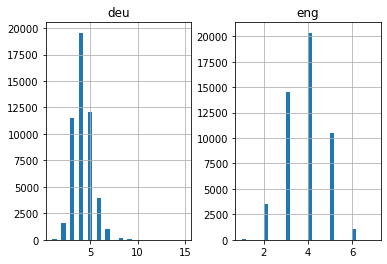

In [7]:
deu_eng
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30)
plt.show()

In [16]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6361


In [17]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10597


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [0]:

from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [0]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [0]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [24]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)




Train on 32000 samples, validate on 8000 samples
Epoch 1/30





32000/32000 [==============================] - 18s 572us/step - loss: 3.5305 - val_loss: 2.9309

Epoch 00001: val_loss improved from inf to 2.93088, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 7s 224us/step - loss: 2.8777 - val_loss: 2.8687

Epoch 00002: val_loss improved from 2.93088 to 2.86872, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 7s 225us/step - loss: 2.7139 - val_loss: 2.6906

Epoch 00003: val_loss improved from 2.86872 to 2.69061, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 7s 227us/step - loss: 2.5312 - val_loss: 2.5508

Epoch 00004: val_loss improved from 2.69061 to 2.55077, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 7s 230us/step - loss: 2.3839 - val_loss: 2.4599

Epoch 00005: val_loss improved from 2.55077 to 

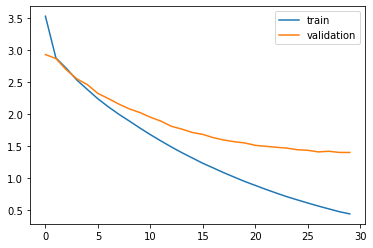

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [28]:
# convert predictions into text (English)
preds_text = []
#print(preds)
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        print(t)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

you
must
be
awake
None
None
None
None
i
feel
old
old
None
None
None
None
im
sorry
for
None
None
None
None
None
is
the
money
money
None
None
None
None
let
me
None
None
None
None
None
None
you
should
work
hard
None
None
None
None
tom
has
a
big
nose
None
None
None
he
lives
her
my
None
None
None
None
whats
is
toms
None
None
None
None
None
i
dont
want
to
go
None
None
None
tom
will
None
None
None
None
None
None
tom
confessed
None
None
None
None
None
None
unlock
the
door
None
None
None
None
None
its
not
good
None
None
None
None
None
i
love
broccoli
None
None
None
None
None
you
must
be
None
None
None
None
None
he
not
not
yet
None
None
None
None
i
do
what
a
None
None
None
None
did
you
enjoy
so
None
None
None
None
she
is
cold
None
None
None
None
None
how
late
is
it
None
None
None
None
thats
a
fact
tree
None
None
None
None
you
are
too
fast
None
None
None
None
why
is
it
None
None
None
None
None
tom
needs
a
job
None
None
None
None
i
have
to
warn
him
None
None
None
the
water
is
filthy
None
None
None

# New Section

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)
pred_df.head(15)

,actual,predicted
0,you need to wake up,you must be awake
1,i feel old,i feel old
2,im sorry tom,i sorry
3,hide the money,its money
4,is someone calling me,let me
5,you should work hard,you work
6,tom has a big problem,tom has a big nose
7,he lives with his mom,he lives on his
8,whats toms job,whats is
9,i dont want to drive,i dont want to go
